# Relación Entre Viajes En Bicicleta y el Clima

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
trips = pd.read_csv('data/trip.csv', low_memory=False)
weather = pd.read_csv('data/weather.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])

In [3]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [4]:
#Se convierte zip_code a string en weather para coincidir con trips.
#NOTA: No se convierte zip_code de trips a int64 por un extraño error en to_numeric.
weather['zip_code'] = weather['zip_code'].astype(str)

In [5]:
#Se combinan los Dataframes.
joined = trips.merge(weather, left_on=['date', 'zip_code'], right_on=['date', 'zip_code'])

## Viajes y Temperatura

En esta serie de plots se analizará si hay una correlación entre los viajes en bicicleta y la temperatura.

Como los registros del clima estan en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climaticas para decidir si realizar un viaje o no. 

### Histograma del Promedio de Temperatura

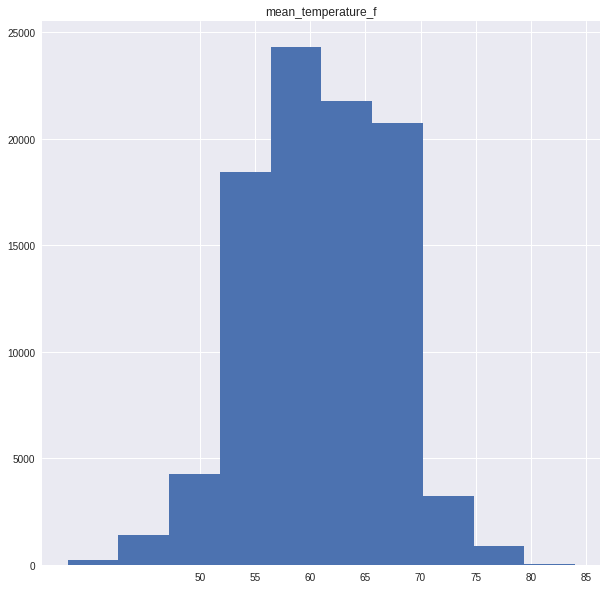

In [6]:
joined.hist(column='mean_temperature_f', grid=True, figsize=(10,10));
plt.xticks(range(50,90,5));

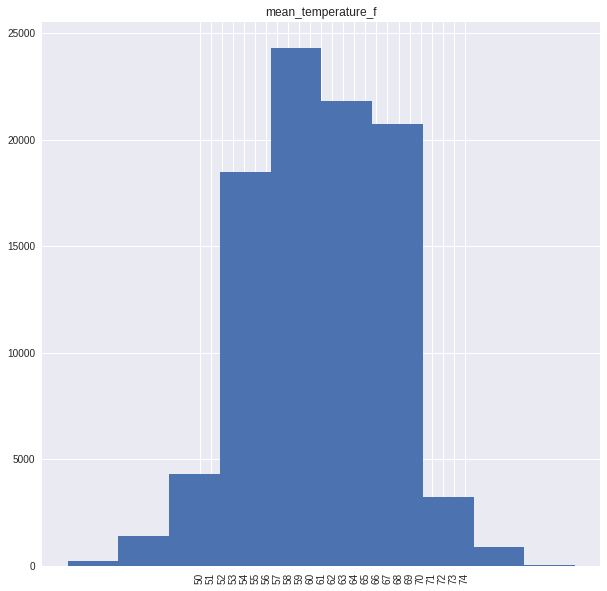

In [7]:
joined.hist(column='mean_temperature_f', grid=True, figsize=(10,10), xrot=90);
plt.xticks(range(50,75,1));

En este histograma se puede apreciar que la mayor cantidad de los viajes se realizan cuando la temperatura promedio esta entre 53°F y 70°F, es decir, entre 11°C y 21°F.  
Si bien puede parecer que la temperatura es algo baja, hay que tener en cuenta que esto es un promedio de la temperatura de todo el día y como San Francisco es una ciudad costera la temperatura suele bajar bastante sobre la noche.

### Histograma de la Temperatura Maxima

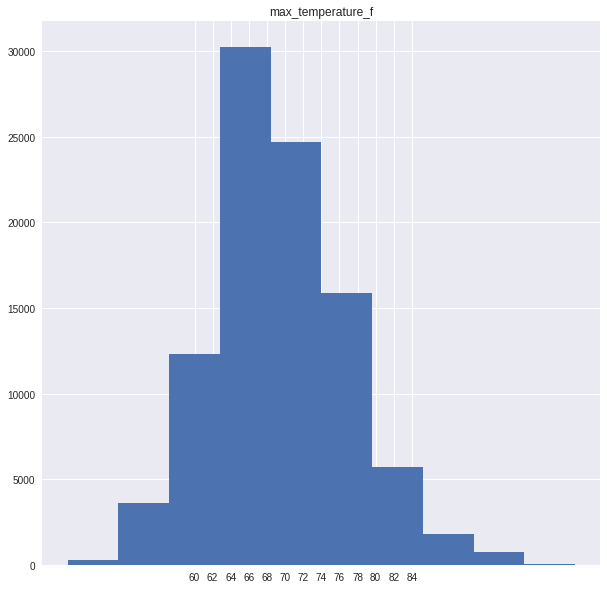

In [8]:
joined.hist(column='max_temperature_f', grid=True, figsize=(10,10))
plt.xticks(range(60,85,2));

De este histograma se puede obtener que la mayoria de los viajes se realizan cuando la temperatura maxima esta entre 64°F y 74°F, es decir, entre 18°C y 23°C.

Si se toman en cuenta los dos histogramas, se puede apreciar que la mayoría de las personas buscan un clima templado a la hora de realizar los viajes.  
No es necesario analizar la temperatura mínima, ya que como se dijo antes, la temperatura suele bajar mucho sobre la noche y daría resultados engañosos.

### Días con Mayor Uso Simultaneo de Biciletas

In [9]:
#Funciones para clasificar.
def f_st(row):
    if row['event'] == 'start_date':
        val = 1
    else:
        val = 0
    return val

def f_en(row):
    if row['event'] == 'end_date':
        val = 1
    else:
        val = 0
    return val

In [10]:
trips_aux = trips[['id', 'start_date', 'end_date', 'zip_code']]
trips_melt = pd.melt(trips_aux, id_vars=['id','zip_code'], value_vars=['start_date', 'end_date'], var_name='event', value_name='time')
trips_melt['time'] = pd.to_datetime(trips_melt['time'])

In [11]:
#Se obtiene la cantidad de bicicletas en uso al mismo tiempo.
trips_ord = trips_melt.sort_values('time', ascending=True) 
trips_ord['start_counter'] = trips_ord.apply(f_st, axis=1)
trips_ord['end_counter'] = trips_ord.apply(f_en, axis=1)
trips_ord['start'] = trips_ord['start_counter'].cumsum()
trips_ord['end'] = trips_ord['end_counter'].cumsum()
trips_ord = trips_ord[['id', 'zip_code', 'time', 'start', 'end']]
trips_ord['in_use'] = trips_ord['start'] - trips_ord['end']
trips_ord = trips_ord.sort_values('in_use', ascending=False)

In [12]:
#Se eliminan los horarios para coincidir con weather.csv.
trips_ord['time'] = trips_ord['time'].apply(lambda x: x.date())
#Se convierte time a datetime64[ns].
trips_ord['time'] = pd.to_datetime(trips_ord['time'])

In [13]:
#Se combinan los Dataframes.
joined_simul = trips_ord.merge(weather, left_on=['time', 'zip_code'], right_on=['date', 'zip_code'])

In [ ]:
joined_simul.plot.bar()